# Applied Economics Analysis1 - Final Assignment
|Name|examnr.|
|----|-------|
|edoardo falchi|2030721|

# Objective and motivation
As [Garcia et al.(2016)](https://link.springer.com/article/10.1007/s10115-016-0995-z) affirm, globalization processes and market deregulation policies are rapidly changing the competitive environments of many economic sectors. The appearance of new competitors and technologies leads to an increase in competition and, with it, a growing preoccupation among service providing companies with creating stronger customer bonds.

["Churn"](https://en.wikipedia.org/wiki/Churn_rate) is the phenomenon where a customer switches from one service to a competitor’s service (Tsai & Chen, 2009). Churn is a relevant issue because anticipating the customer’s intention to abandon the provider becomes a competitive advantage for firms.
Objective of the work is to analyze Churn phenomenon on data coming from Telco Sector and propose the best Target for a Retention Commercial Campaign.

The analysed dataset is taken from https://www.kaggle.com/blastchar/telco-customer-churn where each row represents a customer, each column contains customer’s attributes. The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is the target.

Churn Phenomenon will be described through univariate and bivariate analysis, managing potential issues related to data like outliers and missing.
I will estimate a Scoring Model through Logistic Regression in order to predict Churn Phenomenon, considering the variable Churn in the provided data set as dependent variable.

# Table of contents

*  Univariate and Bivariate Analysis
      * Customer Churn
      * Gender distribution
      * Age distribution
      * Phone Service distribution
      * Internet service distribution
      * Tenure distribution
      * Contract distribution
*  Train-test split
*  Dealing with Missing Values
      * Encoding the dummy variables
*  Dealing with outliers
*  Logistic regression
*  Model evaluation
*  Resampling methods
*  Concluding thoughts
*  Appendix

# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import scipy
from matplotlib import cm
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pylab as pl
import scikitplot as skplt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import plotly.figure_factory as ff
import matplotlib.ticker as mtick
from mlxtend.plotting import plot_confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
tcc = pd.read_csv("tcc.csv")

In [3]:
tcc.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
tcc.shape

(7043, 21)

## Univariate and Bivariate Analysis

### Customer Churn

Let's first have a look at the churn rate.

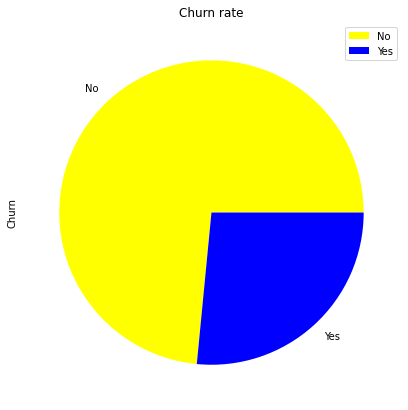

In [5]:
senior = (tcc['Churn'].value_counts()*100.0 /len(tcc)).plot(kind='pie',
        labels = ['No', 'Yes'], figsize = (7,7) , colors = ['yellow','blue'])

senior.set_title('Churn rate')
senior.legend(labels=['No','Yes']);

One customer over four churns.

### Gender distribution

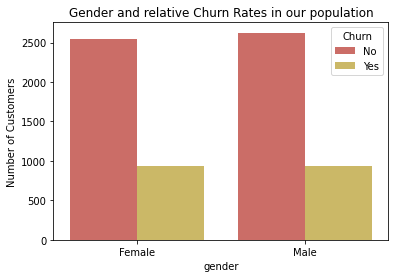

In [6]:
gb = tcc.groupby("gender")["Churn"].value_counts().to_frame().rename({"Churn": "Number of Customers"}, axis = 1).reset_index()
sns.barplot(x = "gender", y = "Number of Customers", data = gb, hue = "Churn", palette = sns.color_palette("hls", 8)).set_title("Gender and relative Churn Rates in our population");

Men and women are evenly distributed in the sample, and show the same proportions of Churn.

### Age distribution

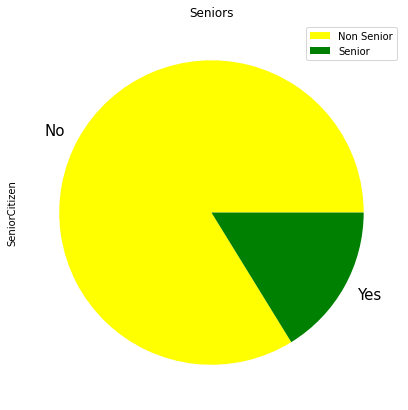

In [7]:
senior = (tcc['SeniorCitizen'].value_counts()*100.0 /len(tcc)).plot(kind='pie',\
        labels = ['No', 'Yes'], figsize = (7,7) , colors = ['yellow','green'], fontsize = 15)

senior.set_title('Seniors')
senior.legend(labels=['Non Senior','Senior']);

In [8]:
gb = tcc.groupby("SeniorCitizen")["Churn"].value_counts().to_frame().rename({"Churn": "Number of Customers"}, axis = 1).reset_index()
gb.replace([0, 1], ["Young", "Senior"], inplace = True)
gb

,SeniorCitizen,Churn,Number of Customers
0,Young,No,4508
1,Young,Yes,1393
2,Senior,No,666
3,Senior,Yes,476


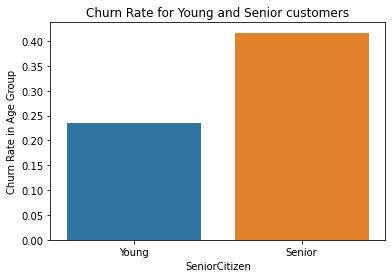

In [9]:
tp = gb.groupby("SeniorCitizen")["Number of Customers"].sum().to_frame().reset_index().rename({"Number of Customers": "# Customers in Age Group"}, axis = 1)
gb = pd.merge(gb, tp, on = "SeniorCitizen")
gb["Churn Rate in Age Group"] = gb["Number of Customers"]/gb["# Customers in Age Group"]
gb = gb[gb.Churn == "Yes"]

sns.barplot(x = "SeniorCitizen", y = "Churn Rate in Age Group", data = gb).set_title("Churn Rate for Young and Senior customers");

This sample is mainly composed by young people. Senior customers are more prone to churning.

### Phone Service distribution

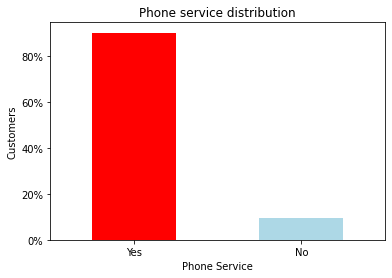

In [10]:
phone = (tcc['PhoneService'].value_counts()*100.0 /len(tcc)).plot(kind='bar', stacked = True,\
                                                rot = 0, color = ['red','lightblue'])
  
phone.yaxis.set_major_formatter(mtick.PercentFormatter())
phone.set_ylabel('Customers')
phone.set_xlabel('Phone Service')
phone.set_title('Phone service distribution');

Just a little amount of people does not have phone service.

### Internet service distribution

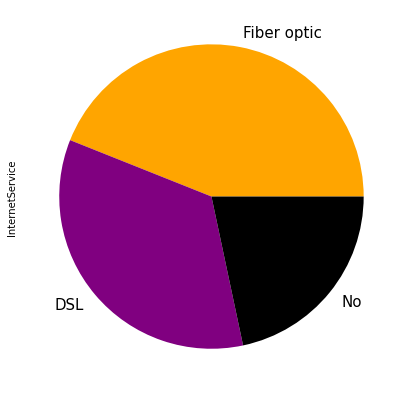

In [11]:
internet = (tcc['InternetService'].value_counts()*100.0 /len(tcc)).plot(kind='pie',\
        labels = ['Fiber optic', 'DSL', 'No'], figsize = (7,7) , colors = ['orange','purple', 'black'], fontsize = 15)

Among the ones that have internet service, DSL and Fiber optic are almost equally distributed (the fraction of people having Fiber optic is slightly greater). Less than one fourth of the members of our sample has no internet service.

### Tenure distribution

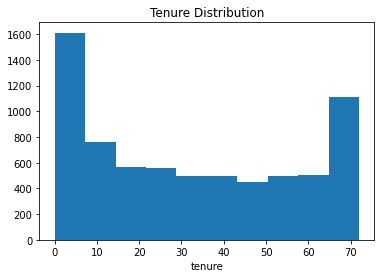

In [12]:
plt.hist(tcc.tenure)
plt.xlabel('tenure')
plt.title("Tenure Distribution");

Tenure indicates the number of months the customer has stayed with the company.  
The majority of the customers in the sample are new clients. There is also a high number of people with a tenure around 70 months. Most likely the company is not older than 72 months, and there either was a strong incentive for subscription (like a competitive launch offer, which could explain the high number through efficient retention rates) or there was some form of selection bias (the offers were unique on the market and highly valued by a group of customers, leading to fast market saturation, which could explain the high number by keeping the retention rate constant and leveraging high sales volumes). These are the only two reasons that can explain such a sharp kickstart in the number of subscriptions and their sudden drop.

### Contract distribution

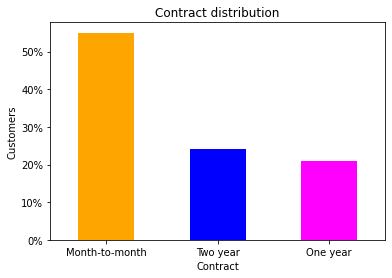

In [13]:
contract = (tcc['Contract'].value_counts()*100.0 /len(tcc)).plot(kind='bar', stacked = True,\
                                                rot = 0, color = ['orange','blue','magenta'])
  
contract.yaxis.set_major_formatter(mtick.PercentFormatter())
contract.set_ylabel('Customers')
contract.set_xlabel('Contract')
contract.set_ylabel('Customers')
contract.set_title('Contract distribution');

More than half customers have a month-to-month contract.

# Train-test split

Before building the predictive model, let's split the dataset into train and test set, in order to measure the accuracy of the model.

In [14]:
msk = np.random.rand(len(tcc)) < 0.8
test = tcc[~msk]
tcc = tcc[msk]

## Dealing with Missing Values

In [15]:
missing_values = []
for col in tcc.columns:
    missing_values.append(tcc[col].isna().any())

missing_values = pd.DataFrame(np.array(missing_values).reshape(1, 21))
missing_values.columns = tcc.columns
missing_values_table   = tcc.append(missing_values).tail(1)
missing_values_table   = missing_values_table.astype(bool)
missing_values_table   = missing_values_table.transpose()
missing_values_table.columns = ["Missing?"]

missing_values_table["dtype"] = tcc.dtypes
missing_values_table

,Missing?,dtype
customerID,False,object
gender,False,object
SeniorCitizen,False,int64
Partner,False,object
Dependents,False,object
tenure,False,int64
PhoneService,False,object
MultipleLines,False,object
InternetService,False,object
OnlineSecurity,False,object


The dtypes are not coherent with logic. There's no point in encoding TotalCharges as a string and MonthlyCharges as a float, or PhoneService as Yes/No and SeniorCitizen as a 0/1 dummy. Let's fix that.

In [16]:
try:
    tcc.TotalCharges.astype("float64")
except ValueError:
    print("We can't convert this column to floats, there must be some non-convertible values")

We can't convert this column to floats, there must be some non-convertible values


In [17]:
print(tcc.TotalCharges.value_counts().head())
print("")
print("We have 11 observations that take an empty string value. Let's drop that. The string we want to drop is:")
tcc.TotalCharges.value_counts().index[1]

20.05    8
         8
20.2     8
19.9     8
45.3     6
Name: TotalCharges, dtype: int64

We have 11 observations that take an empty string value. Let's drop that. The string we want to drop is:


' '

Let's drop the observations with empty values, reset the index and now I should be able to convert the TotalCharges column to float:

In [18]:
def fill_missing(df):
    df.drop(df[df.TotalCharges == " "].index, axis = 0, inplace = True)
    df.reset_index(drop = True, inplace = True)
    df.TotalCharges = df.TotalCharges.astype("float64")
    return df

In [19]:
tcc = fill_missing(tcc)

Let's compute some last computations before extracting the Dummy Variables from the dataset and proceeding to the Regression Part.

In [20]:
for col in tcc.columns:
    print("{0}: {1}".format(col, tcc.loc[:, col].unique()))

customerID: ['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Male' 'Female']
SeniorCitizen: [0 1]
Partner: ['No' 'Yes']
Dependents: ['No' 'Yes']
tenure: [34  2  8 22 10 28 16 58 49 25 69 52 71 21  1 12 30 47 72 17 27  5 46 11
 70 63 43 15 60 18 66  3 31 50 64 56  7 42  9 48 29 65 55 37 36 41  6 33
 13 67 23 57 62 20 53  4 14 32 61 40 59 24 44 19 54 51 68 35 38 26 45 39]
PhoneService: ['Yes' 'No']
MultipleLines: ['No' 'Yes' 'No phone service']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['Yes' 'No' 'No internet service']
OnlineBackup: ['No' 'Yes' 'No internet service']
DeviceProtection: ['Yes' 'No' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['One year' 'Month-to-month' 'Two year']
PaperlessBilling: ['No' 'Yes']
PaymentMethod: ['Mailed check' 'Electronic check' 'Credit card (automatic)'
 'Ba

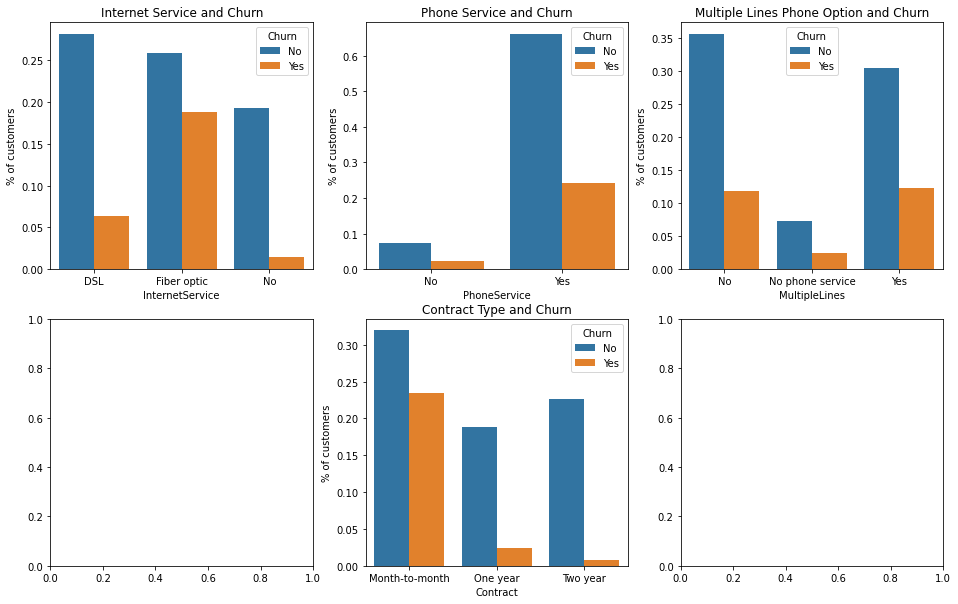

In [21]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))

gb = tcc.groupby("InternetService")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "InternetService", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][0]).set_title("Internet Service and Churn");

gb = tcc.groupby("PhoneService")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "PhoneService", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][1]).set_title("Phone Service and Churn");

gb = tcc.groupby("MultipleLines")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "MultipleLines", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][2]).set_title("Multiple Lines Phone Option and Churn");

gb = tcc.groupby("Contract")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "Contract", y = "% of customers", data = gb, hue = "Churn", ax = axis[1][1]).set_title("Contract Type and Churn");

It is noticeable that the customers with Fiber optic tend to churn a lot more when compared to DSL and No Internet. Maybe the Internet connection offered is low-quality? (Other option: Elder Customers don't need an internet connection. Spoiler: No. See following graph that proves that elderly are proportionally more connected than youngsters and are only a reduced percentage of the population).

MultipleLines do not seem to affect the churn rate.

Shorter-term contract renewals are highly correlated with the churn rate. But most likely it's an omitted variable bias issue: the more I trust a provider, the more I reason in long-terms with it.

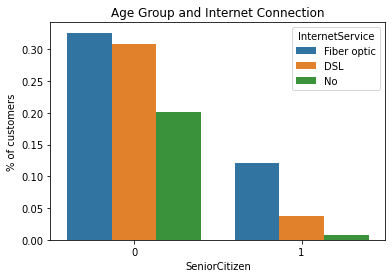

In [22]:
gb = tcc.groupby("SeniorCitizen")["InternetService"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"InternetService": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "SeniorCitizen", y = "% of customers", data = gb, hue = "InternetService").set_title("Age Group and Internet Connection");

Now let's see how the "Additional Internet Services" that follow the variable pattern: ["No", "Yes", "No internet service"] affect the churn rate.

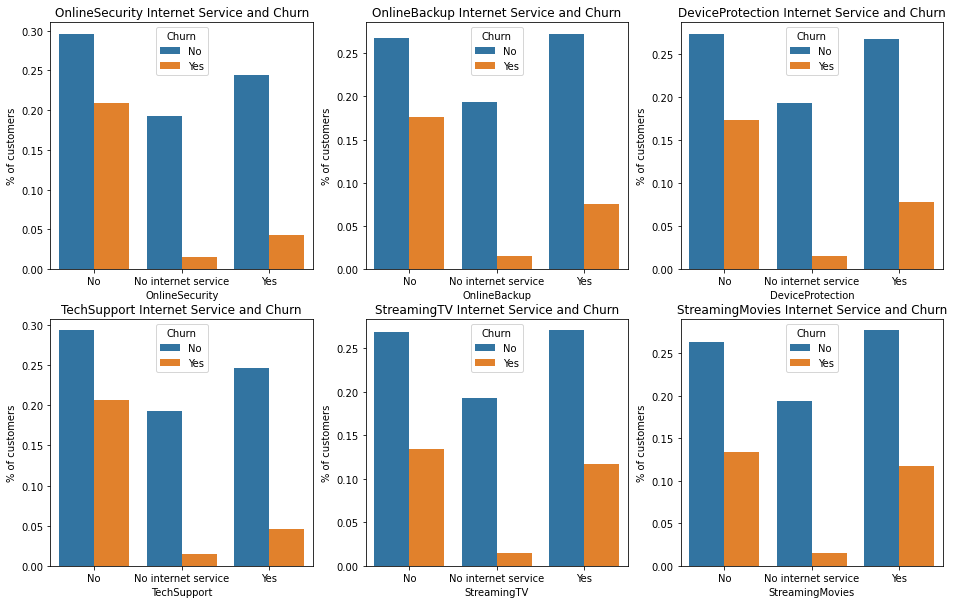

In [23]:
fig, axis = plt.subplots(nrows = 2, ncols = 3, figsize = (16, 10))

gb = tcc.groupby("OnlineSecurity")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "OnlineSecurity", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][0]).set_title("OnlineSecurity Internet Service and Churn")

gb = tcc.groupby("OnlineBackup")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "OnlineBackup", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][1]).set_title("OnlineBackup Internet Service and Churn")

gb = tcc.groupby("DeviceProtection")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "DeviceProtection", y = "% of customers", data = gb, hue = "Churn", ax = axis[0][2]).set_title("DeviceProtection Internet Service and Churn")

gb = tcc.groupby("TechSupport")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "TechSupport", y = "% of customers", data = gb, hue = "Churn", ax = axis[1][0]).set_title("TechSupport Internet Service and Churn")

gb = tcc.groupby("StreamingTV")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "StreamingTV", y = "% of customers", data = gb, hue = "Churn", ax = axis[1][1]).set_title("StreamingTV Internet Service and Churn")

gb = tcc.groupby("StreamingMovies")["Churn"].value_counts()/len(tcc)
gb = gb.to_frame().rename({"Churn": "% of customers"}, axis = 1).reset_index()
sns.barplot(x = "StreamingMovies", y = "% of customers", data = gb, hue = "Churn", ax = axis[1][2]).set_title("StreamingMovies Internet Service and Churn");

- OnlineSecurity, OnlineBackup, TechSupport seem to have a significant impact on lowering the churn. If the company wants to lower the churn rate, It may be a good idea to include these services as standard in the following order: OnlineSecurity, TechSupport, OnlineBackUp, DeviceProtection (although removing the internet connection service altogether may be potentially be more beneficial, at least the Fiber one; see graphs above for details). Although unlikely, it is also possible that these services get cumulated with tenure, and thus their effect on the churn only reflects the negative impact of tenure on the churn rate; in the next cells we will try to figure out whether this is true or not.

- StreamingTV and StreamingMovies do not seem to have a large enough effect on customer Churn Rate.

To assess whether additional services are accumulated through tenure (e.g. fidalty programs), let's run a lmplot for each additional Internet service.

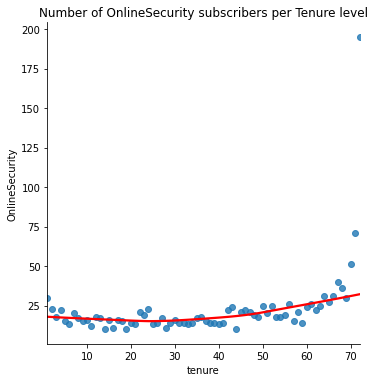

In [24]:
gb = tcc[(tcc.OnlineSecurity != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["OnlineSecurity"].sum().to_frame().reset_index()
sns.lmplot("tenure", "OnlineSecurity", data = gb, line_kws={'color': 'red'}, lowess = True);
ax = plt.gca()
ax.set_title("Number of OnlineSecurity subscribers per Tenure level");

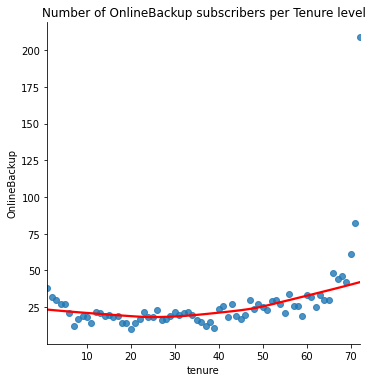

In [25]:
gb = tcc[(tcc.OnlineBackup != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["OnlineBackup"].sum().to_frame().reset_index()
sns.lmplot("tenure", "OnlineBackup", data = gb, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Number of OnlineBackup subscribers per Tenure level");

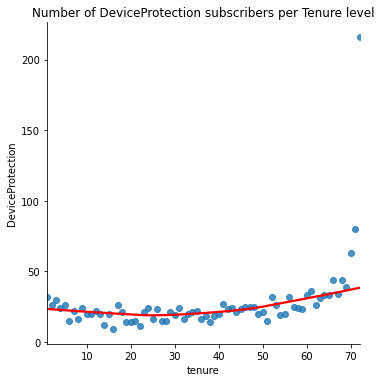

In [26]:
gb = tcc[(tcc.DeviceProtection != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["DeviceProtection"].sum().to_frame().reset_index()
sns.lmplot("tenure", "DeviceProtection", data = gb, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Number of DeviceProtection subscribers per Tenure level");

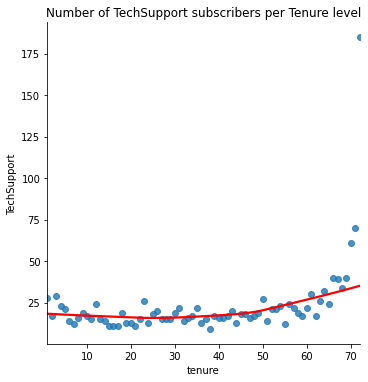

In [27]:
gb = tcc[(tcc.TechSupport != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["TechSupport"].sum().to_frame().reset_index()
sns.lmplot("tenure", "TechSupport", data = gb, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Number of TechSupport subscribers per Tenure level");

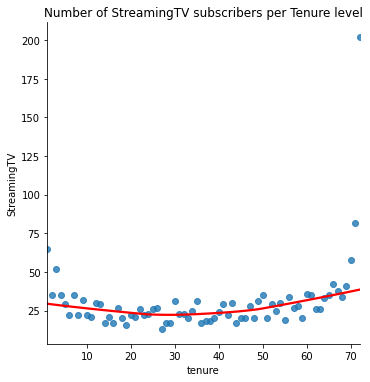

In [28]:
gb = tcc[(tcc.StreamingTV != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["StreamingTV"].sum().to_frame().reset_index()
sns.lmplot("tenure", "StreamingTV", data = gb, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Number of StreamingTV subscribers per Tenure level");

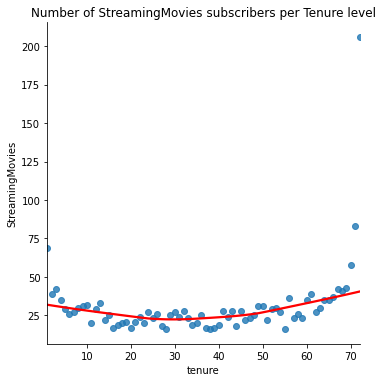

In [29]:
gb = tcc[(tcc.StreamingMovies != "No internet service")].replace(["Yes", "No"], [1, 0]).groupby("tenure")["StreamingMovies"].sum().to_frame().reset_index()
sns.lmplot("tenure", "StreamingMovies", data = gb, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Number of StreamingMovies subscribers per Tenure level");

The absolute number of each Additional Service seems to move in syncro with the others as tenure increases. It does not seem that there is any significant correlation between the number of active Additional Services and tenure, although people with borderline tenures have an extremely high number of Additional Services.

It's weird that so many people with high tenures have so many additional services. Is it just that there are many people with maximum tenure although the percentage of additional services across tenure level stays the same? Hypothesis: at the beginning, the company had a launch offer all-included. Let's check the percentages of people that have these services for each tenure level.

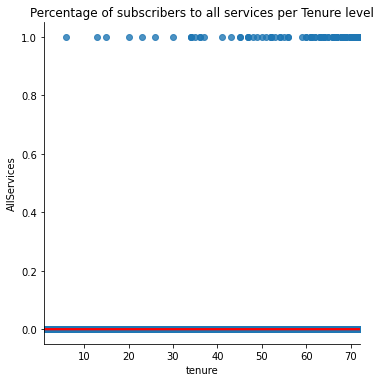

In [30]:
gb = tcc[(tcc.OnlineSecurity != "No internet service")].replace(["Yes", "No"], [1, 0])
gb["AllServices"] = gb.OnlineSecurity*gb.OnlineBackup*gb.DeviceProtection*gb.TechSupport*gb.StreamingTV*gb.StreamingMovies
sns.lmplot("tenure", "AllServices", data = gb, line_kws={'color': 'red'}, lowess = True);
ax = plt.gca()
ax.set_title("Percentage of subscribers to all services per Tenure level");

In [31]:
tvc = gb.tenure.value_counts()
i = []
v = []
for tenure in tvc.index:
    i.append(tenure)
    v.append(len(gb[(gb.tenure == tenure) & (gb.AllServices == 1)])/len(gb[gb.tenure == tenure]))

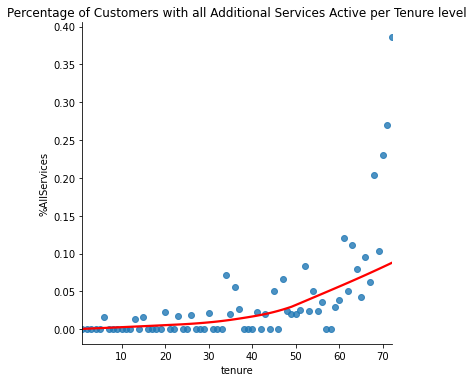

In [32]:
df = pd.DataFrame(data = v, index = i, columns = ["%AllServices"]).reset_index().sort_values("index").reset_index(drop = True).rename({"index": "tenure"}, axis = 1)

sns.lmplot("tenure", "%AllServices", data = df, line_kws={'color': 'red'}, lowess = True)
ax = plt.gca()
ax.set_title("Percentage of Customers with all Additional Services Active per Tenure level");

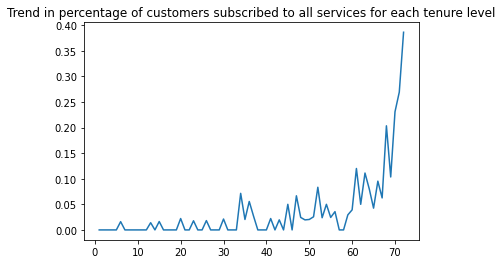

In [33]:
plt.plot(df.tenure, df["%AllServices"]);
ax = plt.gca()
ax.set_title("Trend in percentage of customers subscribed to all services for each tenure level");

Indeed, it seems that the people who subscribed for first have many additional services. Possible explanations:
- Launch offer: all additional services forever included at a discounted price.
- Selection bias: the first customers are the ones who appreciate the most the services offered by the company.

Either case, the hypothesis that additional services are accumulated through tenure can be dismissed, for two reasons:
- There is a strong spike up in the percentage and number of users with all the services around tenure = 70. Nonetheless, the trend in percentage of users with all the services grows constantly, while the absolute number of the individual services stays pretty much constant across tenure levels. This means the the increase in percentage is justifiable only by a convenient launch offer all-inclusive, that rules out the large amount of active offers for customers with extremely high tenure. _(Regression in the Appendix confirms this result.)_
- if there was a cumulation of benefits, the drop on the 69th tenure value could be hardly justifiable, whereas it could be justified by a change in the offer or a decrease in interest towards the company.

### Encoding the dummy variables

In [34]:
def get_dummy(df):
    df = pd.get_dummies(df.iloc[:, 1 :])
    return df

In [35]:
tcc = get_dummy(tcc)
tcc.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_No,Churn_Yes
0,0,34,56.95,1889.50,0,1,1,0,1,0,...,1,0,1,0,0,0,0,1,1,0
1,0,2,53.85,108.15,0,1,1,0,1,0,...,0,0,0,1,0,0,0,1,0,1
2,0,2,70.70,151.65,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
3,0,8,99.65,820.50,1,0,1,0,1,0,...,0,0,0,1,0,0,1,0,0,1
4,0,22,89.10,1949.40,0,1,1,0,0,1,...,0,0,0,1,0,1,0,0,1,0


In [36]:
tcc.dtypes

SeniorCitizen                                int64
tenure                                       int64
MonthlyCharges                             float64
TotalCharges                               float64
gender_Female                                uint8
gender_Male                                  uint8
Partner_No                                   uint8
Partner_Yes                                  uint8
Dependents_No                                uint8
Dependents_Yes                               uint8
PhoneService_No                              uint8
PhoneService_Yes                             uint8
MultipleLines_No                             uint8
MultipleLines_No phone service               uint8
MultipleLines_Yes                            uint8
InternetService_DSL                          uint8
InternetService_Fiber optic                  uint8
InternetService_No                           uint8
OnlineSecurity_No                            uint8
OnlineSecurity_No internet serv

Let's have a look at the variables.

In [37]:
for col in tcc.columns:
    print("{0}: {1}".format(col, tcc.loc[:, col].unique()))

SeniorCitizen: [0 1]
tenure: [34  2  8 22 10 28 16 58 49 25 69 52 71 21  1 12 30 47 72 17 27  5 46 11
 70 63 43 15 60 18 66  3 31 50 64 56  7 42  9 48 29 65 55 37 36 41  6 33
 13 67 23 57 62 20 53  4 14 32 61 40 59 24 44 19 54 51 68 35 38 26 45 39]
MonthlyCharges: [ 56.95  53.85  70.7  ...  39.   108.35  63.1 ]
TotalCharges: [1889.5   108.15  151.65 ...  346.45  306.6  6844.5 ]
gender_Female: [0 1]
gender_Male: [1 0]
Partner_No: [1 0]
Partner_Yes: [0 1]
Dependents_No: [1 0]
Dependents_Yes: [0 1]
PhoneService_No: [0 1]
PhoneService_Yes: [1 0]
MultipleLines_No: [1 0]
MultipleLines_No phone service: [0 1]
MultipleLines_Yes: [0 1]
InternetService_DSL: [1 0]
InternetService_Fiber optic: [0 1]
InternetService_No: [0 1]
OnlineSecurity_No: [0 1]
OnlineSecurity_No internet service: [0 1]
OnlineSecurity_Yes: [1 0]
OnlineBackup_No: [1 0]
OnlineBackup_No internet service: [0 1]
OnlineBackup_Yes: [0 1]
DeviceProtection_No: [0 1]
DeviceProtection_No internet service: [0 1]
DeviceProtection_Yes: [1 0

# Dealing with outliers

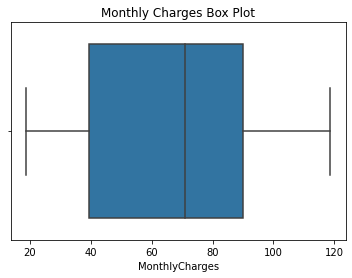

In [38]:
sns.boxplot(x = tcc.MonthlyCharges).set_title("Monthly Charges Box Plot");

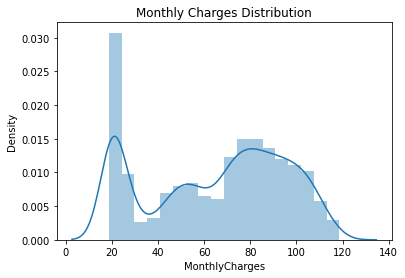

In [39]:
sns.distplot(tcc.MonthlyCharges).set_title("Monthly Charges Distribution");

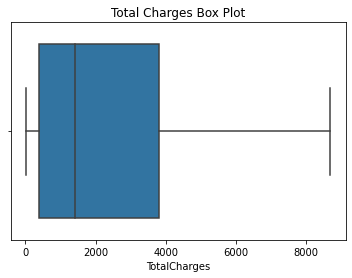

In [40]:
sns.boxplot(x = tcc.TotalCharges).set_title("Total Charges Box Plot");

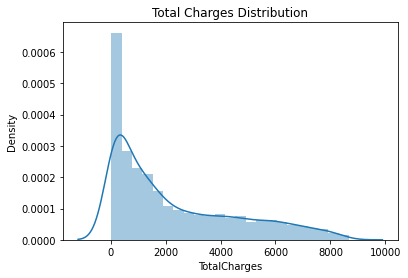

In [41]:
sns.distplot(tcc.TotalCharges).set_title("Total Charges Distribution");

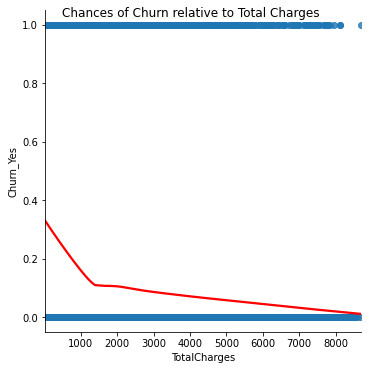

In [42]:
sns.lmplot("TotalCharges", "Churn_Yes", data = tcc, line_kws={'color': 'red'}, lowess = True, size = 5)
plt.suptitle("Chances of Churn relative to Total Charges");

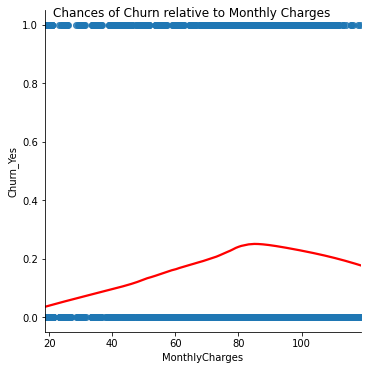

In [43]:
sns.lmplot("MonthlyCharges", "Churn_Yes", data = tcc, line_kws={'color': 'red'}, lowess = True, size = 5)
plt.suptitle("Chances of Churn relative to Monthly Charges");

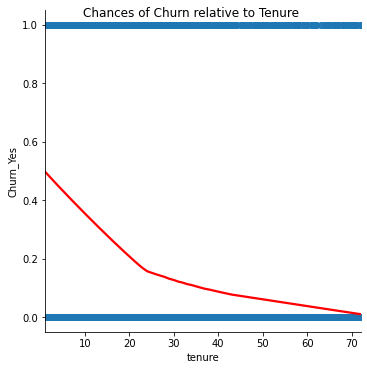

In [44]:
sns.lmplot("tenure", "Churn_Yes", data = tcc, line_kws={'color': 'red'}, lowess = True, size = 5)
plt.suptitle("Chances of Churn relative to Tenure");

# Logistic regression

I want to build a predictive model using Churn as dependent variable. First let's run the regression by including all the variables.

In [45]:
tcc.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Female', 'gender_Male', 'Partner_No', 'Partner_Yes',
       'Dependents_No', 'Dependents_Yes', 'PhoneService_No',
       'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', '

Most of the variables differentiate between "No" and "No internet service". Given that the information about "Internet Service" or "No internet service" is already provided by the variable InternetService, we can just analyze the impact of having a service that implies having Internet Service versus not having it, without considering that a person could have for example no OnlineSecurity due to the fact that they do not have Internet Service.

TotalCharges can also be excluded from the model, since it is likely to be correlated with MonthlyCharges (I am going to test this hypothesis by calculating the Pearson correlation coefficient).

In [46]:
# Pearson correlation coefficient
print("Coefficient:",scipy.stats.pearsonr(tcc["MonthlyCharges"], tcc["TotalCharges"])[0])
print("p-value:",scipy.stats.pearsonr(tcc["MonthlyCharges"], tcc["TotalCharges"])[1])

Coefficient: 0.6471564131497883
p-value: 0.0


The two variables are highly correlated.

Let's run a first regression including all the variables, and then progressively improve the model.

In [47]:
# Intercept
tcc["intercept"] = 1.0

variables = tcc.copy()[['SeniorCitizen', 'tenure', 'MonthlyCharges', 
       'gender_Female', 'Partner_Yes', 'PhoneService_Yes',
        'Dependents_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'intercept']]

# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Logit
========================================================================================
Model:                       Logit                     Pseudo R-squared:          inf   
Dependent Variable:          Churn_Yes                 AIC:                       inf   
Date:                        2021-08-23 18:41          BIC:                       inf   
No. Observations:            5631                      Log-Likelihood:            -inf  
Df Model:                    22                        LL-Null:                   0.0000
Df Residuals:                5608                      LLR p-value:               1.0000
Converged:                   1.0000                    Scale:                     1.0000
No. Iterations:              8.0000                                                     
----------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------------------
SeniorCitizen                            0.2240   0.0941   2.3805 0.0173  0.0396  0.4084
tenure                                  -0.0325   0.0026 -12.3750 0.0000 -0.0376 -0.0273
MonthlyCharges                          -0.0274   0.0351  -0.7813 0.4346 -0.0962  0.0414
gender_Female                           -0.0098   0.0720  -0.1366 0.8913 -0.1509  0.1313
Partner_Yes                              0.0315   0.0866   0.3640 0.7159 -0.1381  0.2012
PhoneService_Yes                        -0.0126   0.7173  -0.0175 0.9860 -1.4185  1.3933
Dependents_Yes                          -0.1652   0.1003  -1.6475 0.0995 -0.3617  0.0313
MultipleLines_Yes                        0.3894   0.1960   1.9861 0.0470  0.0051  0.7736
InternetService_DSL                      1.4725   0.8930   1.6489 0.0992 -0.2778  3.2228
InternetService_Fiber optic              3.1550   1.7636   1.7890 0.0736 -0.3016  6.6117
OnlineSecurity_Yes                      -0.2127   0.1981  -1.0737 0.2830 -0.6009  0.1755
OnlineBackup_Yes                         0.0041   0.1933   0.0212 0.9830 -0.3747  0.3829
DeviceProtection_Yes                     0.1138   0.1953   0.5825 0.5602 -0.2690  0.4966
TechSupport_Yes                         -0.1457   0.2001  -0.7283 0.4664 -0.5379  0.2465
StreamingTV_Yes                          0.5486   0.3608   1.5203 0.1284 -0.1586  1.2557
StreamingMovies_Yes                      0.5239   0.3615   1.4492 0.1473 -0.1847  1.2325
Contract_One year                       -0.6692   0.1190  -5.6233 0.0000 -0.9025 -0.4360
Contract_Two year                       -1.2678   0.1901  -6.6707 0.0000 -1.6404 -0.8953
PaperlessBilling_Yes                     0.2552   0.0829   3.0781 0.0021  0.0927  0.4177
PaymentMethod_Bank transfer (automatic) -0.0308   0.1266  -0.2429 0.8081 -0.2789  0.2174
PaymentMethod_Credit card (automatic)   -0.0642   0.1291  -0.4976 0.6188 -0.3173  0.1888
PaymentMethod_Electronic check           0.3224   0.1065   3.0274 0.0025  0.1137  0.5311
intercept                               -0.9868   0.1965  -5.0227 0.0000 -1.3719 -0.6017
========================================================================================

"""

To improve results' goodness PaymentMethod can be transformed in order to analyze the difference between automatic Payment Method and non automatic. Clients with automatic payment are less likely to churn with respect to clients with no automatic payment. I am not interested in the difference between Bank transfer and Credit card, or between Electronic check or Mailed check.

In [48]:
# Transforming PaymentMethod
def transform_payment(df):
    df["PaymentMethod_Automatic"] = df["PaymentMethod_Bank transfer (automatic)"] + df["PaymentMethod_Credit card (automatic)"]
    return df

tcc = transform_payment(tcc)

In [49]:
variables = tcc[['SeniorCitizen', 'tenure', 'MonthlyCharges', 
       'gender_Female', 'Partner_Yes',
        'Dependents_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'intercept']]

# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                   Logit                 Pseudo R-squared:      inf   
Dependent Variable:      Churn_Yes             AIC:                   inf   
Date:                    2021-08-23 18:41      BIC:                   inf   
No. Observations:        5631                  Log-Likelihood:        -inf  
Df Model:                19                    LL-Null:               0.0000
Df Residuals:            5611                  LLR p-value:           1.0000
Converged:               1.0000                Scale:                 1.0000
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
SeniorCitizen                0.2372   0.0939   2.5273 0.0115  0.0532  0.4211
tenure                      -0.0320   0.0026 -12.2124 0.0000 -0.0371 -0.0268
MonthlyCharges              -0.0284   0.0069  -4.1369 0.0000 -0.0419 -0.0150
gender_Female               -0.0067   0.0719  -0.0930 0.9259 -0.1475  0.1341
Partner_Yes                  0.0409   0.0863   0.4737 0.6357 -0.1283  0.2101
Dependents_Yes              -0.1726   0.1001  -1.7254 0.0845 -0.3687  0.0235
MultipleLines_Yes            0.3956   0.0998   3.9627 0.0001  0.2000  0.5913
InternetService_DSL          1.5796   0.1946   8.1162 0.0000  1.1982  1.9611
InternetService_Fiber optic  3.3346   0.3741   8.9126 0.0000  2.6013  4.0679
OnlineSecurity_Yes          -0.2217   0.1000  -2.2157 0.0267 -0.4178 -0.0256
OnlineBackup_Yes             0.0081   0.0901   0.0903 0.9280 -0.1685  0.1848
DeviceProtection_Yes         0.1142   0.0925   1.2346 0.2170 -0.0671  0.2955
TechSupport_Yes             -0.1615   0.1020  -1.5829 0.1134 -0.3614  0.0385
StreamingTV_Yes              0.5744   0.1100   5.2203 0.0000  0.3587  0.7900
StreamingMovies_Yes          0.5493   0.1090   5.0376 0.0000  0.3356  0.7631
Contract_One year           -0.6872   0.1188  -5.7849 0.0000 -0.9201 -0.4544
Contract_Two year           -1.2934   0.1897  -6.8181 0.0000 -1.6652 -0.9216
PaperlessBilling_Yes         0.2760   0.0825   3.3461 0.0008  0.1144  0.4377
PaymentMethod_Automatic     -0.2773   0.0806  -3.4407 0.0006 -0.4353 -0.1193
intercept                   -0.8904   0.1911  -4.6599 0.0000 -1.2649 -0.5159
============================================================================

"""

Now, remove from the model OnlineBackup, DeviceProtection, gender and partner as they are not significant.

In [50]:
variables = tcc[['SeniorCitizen', 'tenure', 'MonthlyCharges', 
        'Dependents_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'intercept']]

# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                   Logit                 Pseudo R-squared:      inf   
Dependent Variable:      Churn_Yes             AIC:                   inf   
Date:                    2021-08-23 18:41      BIC:                   inf   
No. Observations:        5631                  Log-Likelihood:        -inf  
Df Model:                15                    LL-Null:               0.0000
Df Residuals:            5615                  LLR p-value:           1.0000
Converged:               1.0000                Scale:                 1.0000
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
SeniorCitizen                0.2460   0.0930   2.6440 0.0082  0.0637  0.4284
tenure                      -0.0313   0.0025 -12.6833 0.0000 -0.0361 -0.0264
MonthlyCharges              -0.0255   0.0060  -4.2228 0.0000 -0.0373 -0.0136
Dependents_Yes              -0.1533   0.0909  -1.6855 0.0919 -0.3315  0.0250
MultipleLines_Yes            0.3744   0.0966   3.8762 0.0001  0.1851  0.5638
InternetService_DSL          1.5430   0.1912   8.0703 0.0000  1.1683  1.9178
InternetService_Fiber optic  3.2086   0.3471   9.2435 0.0000  2.5283  3.8889
OnlineSecurity_Yes          -0.2390   0.0984  -2.4293 0.0151 -0.4318 -0.0462
TechSupport_Yes             -0.1732   0.1010  -1.7148 0.0864 -0.3712  0.0248
StreamingTV_Yes              0.5564   0.1070   5.2013 0.0000  0.3468  0.7661
StreamingMovies_Yes          0.5334   0.1059   5.0371 0.0000  0.3259  0.7410
Contract_One year           -0.6780   0.1185  -5.7217 0.0000 -0.9103 -0.4458
Contract_Two year           -1.2785   0.1892  -6.7557 0.0000 -1.6494 -0.9076
PaperlessBilling_Yes         0.2740   0.0824   3.3245 0.0009  0.1124  0.4355
PaymentMethod_Automatic     -0.2740   0.0805  -3.4036 0.0007 -0.4318 -0.1162
intercept                   -0.9567   0.1715  -5.5770 0.0000 -1.2929 -0.6205
============================================================================

"""

To improve regression interpretability, instead of considering tenure as a continuous variable, let's divide it into 4 clusters

In [51]:
def cluster(df):
    df["tenure_0:18"]  = 0
    df["tenure_19:36"] = 0
    df["tenure_37:54"] = 0
    df["tenure_55:72"] = 0

    df.loc[df.tenure <= 18, "tenure_0:18"] = 1
    df.loc[((df.tenure >= 19) & (df.tenure <= 36)), "tenure_19:36"] = 1
    df.loc[((df.tenure >= 37) & (df.tenure <= 54)), "tenure_37:54"] = 1
    df.loc[df.tenure >= 55, "tenure_55:72"] = 1
    
    return df

tcc = cluster(tcc)

Let's run a new regression.

In [52]:
variables = tcc[['SeniorCitizen', 'MonthlyCharges', 
        'Dependents_Yes', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'tenure_19:36',
       'tenure_37:54', 'tenure_55:72','intercept']]

# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                              Results: Logit
===========================================================================
Model:                    Logit                Pseudo R-squared:     inf   
Dependent Variable:       Churn_Yes            AIC:                  inf   
Date:                     2021-08-23 18:41     BIC:                  inf   
No. Observations:         5631                 Log-Likelihood:       -inf  
Df Model:                 17                   LL-Null:              0.0000
Df Residuals:             5613                 LLR p-value:          1.0000
Converged:                1.0000               Scale:                1.0000
No. Iterations:           8.0000                                           
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
SeniorCitizen                0.2221   0.0925  2.4017 0.0163  0.0409  0.4034
MonthlyCharges              -0.0271   0.0060 -4.4827 0.0000 -0.0389 -0.0152
Dependents_Yes              -0.1569   0.0909 -1.7266 0.0842 -0.3350  0.0212
MultipleLines_Yes            0.3346   0.0965  3.4651 0.0005  0.1453  0.5238
InternetService_DSL          1.5670   0.1911  8.2018 0.0000  1.1926  1.9415
InternetService_Fiber optic  3.2728   0.3476  9.4142 0.0000  2.5914  3.9542
OnlineSecurity_Yes          -0.2681   0.0982 -2.7300 0.0063 -0.4605 -0.0756
TechSupport_Yes             -0.1677   0.1011 -1.6587 0.0972 -0.3659  0.0305
StreamingTV_Yes              0.5522   0.1071  5.1563 0.0000  0.3423  0.7621
StreamingMovies_Yes          0.5284   0.1060  4.9866 0.0000  0.3207  0.7361
Contract_One year           -0.8078   0.1178 -6.8558 0.0000 -1.0387 -0.5769
Contract_Two year           -1.5668   0.1915 -8.1822 0.0000 -1.9421 -1.1915
PaperlessBilling_Yes         0.2647   0.0825  3.2100 0.0013  0.1031  0.4263
PaymentMethod_Automatic     -0.3158   0.0801 -3.9414 0.0001 -0.4729 -0.1588
tenure_19:36                -0.9740   0.1014 -9.6055 0.0000 -1.1727 -0.7752
tenure_37:54                -0.9905   0.1204 -8.2233 0.0000 -1.2265 -0.7544
tenure_55:72                -1.4900   0.1499 -9.9434 0.0000 -1.7837 -1.1963
intercept                   -1.0077   0.1725 -5.8433 0.0000 -1.3457 -0.6697
===========================================================================

"""

Let's calculate the Variance Inflation Factor to see if there is multicollinearity among variables. VIF measures how much the behavior (variance) of an independent variable is influenced, or inflated, by its interaction/correlation with the other independent variables.

In [53]:
vif = pd.DataFrame()
vif["Variables"]  = variables.columns[0:-1]
vif["VIF Factor"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1]-1)]
vif

,Variables,VIF Factor
0,SeniorCitizen,1.141306
1,MonthlyCharges,25.286909
2,Dependents_Yes,1.120706
3,MultipleLines_Yes,1.787921
4,InternetService_DSL,6.189891
5,InternetService_Fiber optic,22.908178
6,OnlineSecurity_Yes,1.584837
7,TechSupport_Yes,1.696872
8,StreamingTV_Yes,2.336489
9,StreamingMovies_Yes,2.286928


The two InternetService variables have a high VIF, along with MonthlyCharges. A possible explanation is that customers who have the Optic Fiber connection pay a different price compared to those who have a DSL connection. For this reason, it's advisable excluding MonthlyCharges , and then re-run VIF analysis. I should expect a low VIF for both InternetService variables.

I am also going to re-insert in our regression OnlineBackup and DeviceProtection, which were removed earlier on, as they might have been affected by multicollinearity.

In [54]:
variables = tcc[['SeniorCitizen',
        'Dependents_Yes', 'MultipleLines_Yes',
         'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', "OnlineBackup_Yes", "DeviceProtection_Yes", 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'tenure_19:36',
       'tenure_37:54', 'tenure_55:72','intercept']]

vif = pd.DataFrame()
vif["Variables"]  = variables.columns[0:-1]
vif["VIF Factor"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1]-1)]
vif

,Variables,VIF Factor
0,SeniorCitizen,1.139493
1,Dependents_Yes,1.120909
2,MultipleLines_Yes,1.326987
3,InternetService_DSL,3.252100
4,InternetService_Fiber optic,3.917592
5,OnlineSecurity_Yes,1.388029
6,TechSupport_Yes,1.474212
7,OnlineBackup_Yes,1.359113
8,DeviceProtection_Yes,1.455846
9,StreamingTV_Yes,1.620769


Indeed, data proves that MonthlyCharges greatly depend on InternetService.

Now, let's just run the logistic regression as before, this time without MonthlyCharges.

In [55]:
# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                   Logit                 Pseudo R-squared:      inf   
Dependent Variable:      Churn_Yes             AIC:                   inf   
Date:                    2021-08-23 18:41      BIC:                   inf   
No. Observations:        5631                  Log-Likelihood:        -inf  
Df Model:                18                    LL-Null:               0.0000
Df Residuals:            5612                  LLR p-value:           1.0000
Converged:               1.0000                Scale:                 1.0000
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
SeniorCitizen                0.2457   0.0923   2.6613 0.0078  0.0648  0.4267
Dependents_Yes              -0.1601   0.0907  -1.7650 0.0776 -0.3379  0.0177
MultipleLines_Yes            0.1341   0.0844   1.5894 0.1120 -0.0313  0.2995
InternetService_DSL          1.0574   0.1471   7.1887 0.0000  0.7691  1.3457
InternetService_Fiber optic  1.9217   0.1503  12.7860 0.0000  1.6271  2.2163
OnlineSecurity_Yes          -0.4109   0.0927  -4.4338 0.0000 -0.5925 -0.2293
TechSupport_Yes             -0.3244   0.0941  -3.4455 0.0006 -0.5089 -0.1398
OnlineBackup_Yes            -0.1922   0.0833  -2.3068 0.0211 -0.3556 -0.0289
DeviceProtection_Yes        -0.0582   0.0858  -0.6779 0.4979 -0.2264  0.1100
StreamingTV_Yes              0.2862   0.0876   3.2679 0.0011  0.1145  0.4578
StreamingMovies_Yes          0.2645   0.0871   3.0357 0.0024  0.0937  0.4353
Contract_One year           -0.8245   0.1183  -6.9718 0.0000 -1.0562 -0.5927
Contract_Two year           -1.5799   0.1924  -8.2101 0.0000 -1.9570 -1.2027
PaperlessBilling_Yes         0.2720   0.0823   3.3053 0.0009  0.1107  0.4333
PaymentMethod_Automatic     -0.3223   0.0800  -4.0268 0.0001 -0.4791 -0.1654
tenure_19:36                -0.9548   0.1016  -9.3969 0.0000 -1.1539 -0.7556
tenure_37:54                -0.9516   0.1224  -7.7762 0.0000 -1.1915 -0.7118
tenure_55:72                -1.4433   0.1539  -9.3793 0.0000 -1.7449 -1.1417
intercept                   -1.5418   0.1282 -12.0253 0.0000 -1.7931 -1.2905
============================================================================

"""

OnlineBackup is now significant, whereas DeviceProtection stays unsignificant. So the latter can be removed from the model.

In [56]:
variables = tcc[['SeniorCitizen',
        'Dependents_Yes', 'MultipleLines_Yes',
         'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', "OnlineBackup_Yes", 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'tenure_19:36',
       'tenure_37:54', 'tenure_55:72','intercept']]

# Setting the model
logistical_regression = sm.Logit(tcc["Churn_Yes"], variables)

# Fitting the model
fitted_model = logistical_regression.fit()
fitted_model.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                   Logit                 Pseudo R-squared:      inf   
Dependent Variable:      Churn_Yes             AIC:                   inf   
Date:                    2021-08-23 18:41      BIC:                   inf   
No. Observations:        5631                  Log-Likelihood:        -inf  
Df Model:                17                    LL-Null:               0.0000
Df Residuals:            5613                  LLR p-value:           1.0000
Converged:               1.0000                Scale:                 1.0000
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
SeniorCitizen                0.2452   0.0923   2.6564 0.0079  0.0643  0.4261
Dependents_Yes              -0.1603   0.0907  -1.7674 0.0772 -0.3381  0.0175
MultipleLines_Yes            0.1333   0.0844   1.5798 0.1142 -0.0321  0.2986
InternetService_DSL          1.0461   0.1461   7.1582 0.0000  0.7596  1.3325
InternetService_Fiber optic  1.9091   0.1491  12.8014 0.0000  1.6168  2.2014
OnlineSecurity_Yes          -0.4100   0.0927  -4.4246 0.0000 -0.5916 -0.2284
TechSupport_Yes             -0.3280   0.0940  -3.4894 0.0005 -0.5122 -0.1437
OnlineBackup_Yes            -0.1933   0.0833  -2.3206 0.0203 -0.3566 -0.0300
StreamingTV_Yes              0.2801   0.0871   3.2166 0.0013  0.1094  0.4508
StreamingMovies_Yes          0.2576   0.0865   2.9779 0.0029  0.0881  0.4272
Contract_One year           -0.8316   0.1178  -7.0587 0.0000 -1.0625 -0.6007
Contract_Two year           -1.5902   0.1919  -8.2879 0.0000 -1.9663 -1.2142
PaperlessBilling_Yes         0.2733   0.0823   3.3213 0.0009  0.1120  0.4345
PaymentMethod_Automatic     -0.3243   0.0800  -4.0548 0.0001 -0.4810 -0.1675
tenure_19:36                -0.9579   0.1015  -9.4395 0.0000 -1.1569 -0.7590
tenure_37:54                -0.9594   0.1219  -7.8725 0.0000 -1.1982 -0.7205
tenure_55:72                -1.4537   0.1532  -9.4913 0.0000 -1.7539 -1.1535
intercept                   -1.5381   0.1281 -12.0089 0.0000 -1.7891 -1.2870
============================================================================

"""

**THIS IS THE FINAL MODEL.** Let's get the marginal effect of the variables in order to be able to easily interpret them.

In [57]:
margeff = fitted_model.get_margeff()
margeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:              Churn_Yes
Method:                          dydx
At:                           overall
===============================================================================================
                                 dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
SeniorCitizen                   0.0341      0.013      2.664      0.008       0.009       0.059
Dependents_Yes                 -0.0223      0.013     -1.769      0.077      -0.047       0.002
MultipleLines_Yes               0.0185      0.012      1.581      0.114      -0.004       0.042
InternetService_DSL             0.1455      0.020      7.272      0.000       0.106       0.185
InternetService_Fiber optic     0.2655      0.020     13.583      0.000       0.227       0.304
OnlineSecurity_Yes             -0.0570      0.013     -4.456      0.000      -0.082      -0.032
TechSupport_Yes                -0.0456      0.013     -3.506      0.000      -0.071      -0.020
OnlineBackup_Yes               -0.0269      0.012     -2.326      0.020      -0.050      -0.004
StreamingTV_Yes                 0.0390      0.012      3.228      0.001       0.015       0.063
StreamingMovies_Yes             0.0358      0.012      2.987      0.003       0.012       0.059
Contract_One year              -0.1157      0.016     -7.157      0.000      -0.147      -0.084
Contract_Two year              -0.2212      0.027     -8.336      0.000      -0.273      -0.169
PaperlessBilling_Yes            0.0380      0.011      3.335      0.001       0.016       0.060
PaymentMethod_Automatic        -0.0451      0.011     -4.078      0.000      -0.067      -0.023
tenure_19:36                   -0.1332      0.014     -9.770      0.000      -0.160      -0.107
tenure_37:54                   -0.1334      0.017     -8.072      0.000      -0.166      -0.101
tenure_55:72                   -0.2022      0.021     -9.830      0.000      -0.243      -0.162
===============================================================================================
"""

Results: 
- Both _InternetService_ variables present a positive impact on the churn rate, with Optic Fiber's being almost twice the of DSL's. It might be a good idea to consider discontinuing at least the Optic Fiber service or improving it.
- Senior customers tend to churn more easily.
- Additional Internet Services (_OnlineSecurity_, _TechSupport_, _OnlineBackup_) negatively affect Churn Rate and are therefore a potential way to decrease it in a managerial setting. _DeviceProtection_ on the other hand is inconsistent with plottings, and it appears that its effect is largely explained by the other variables of the model. _StreamingMovies_ and _StreamingTV_ are significant and positively affect the Churn Rate: the management might consider stop offering those services.

---

# Model evaluation

Let's fit this logistic regression to the test data to evaluate the effectiveness of the final model.

In [58]:
test = fill_missing(test)
test = get_dummy(test)
test = transform_payment(test)
test = cluster(test)

In [59]:
test["intercept"] = 1.0

variables = test[['SeniorCitizen',
        'Dependents_Yes', 'MultipleLines_Yes',
         'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', "OnlineBackup_Yes", 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'tenure_19:36',
       'tenure_37:54', 'tenure_55:72','intercept']]

y = test.Churn_Yes

In [60]:
model_predict = fitted_model.predict(variables)

Let's measure the goodness of the model by building the confusion matrix.

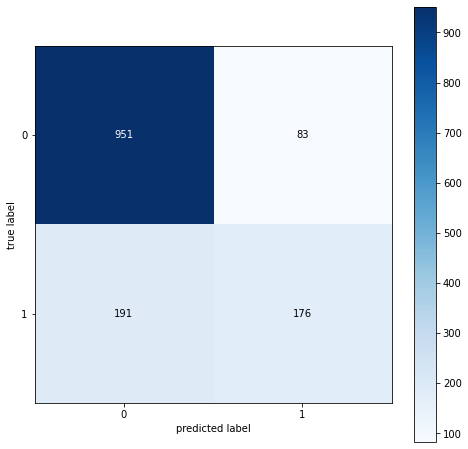

In [61]:
pred = model_predict.copy()
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0

cm = skplt.metrics.confusion_matrix(y_true=y, y_pred=pred)
plot_confusion_matrix(cm, figsize=(8, 8), colorbar=True);

Now plot the Kolmogorov–Smirnov statistics in order to set a better probability threshold for the prediction.

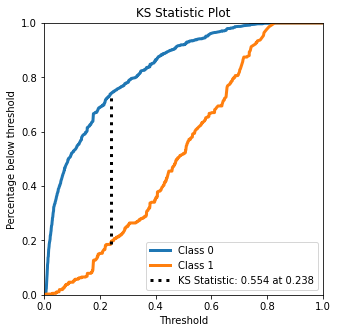

In [62]:
# Compute the predicted probability
proba = np.array([ 1 - model_predict, model_predict ])

skplt.metrics.plot_ks_statistic(test["Churn_Yes"], proba.T, figsize=(5, 5));

0.326 is going to be the optimal threshold.  
**BUSINESS CASE SOLUTION:** consider as potential churners all the observations with a predicted probability of churning greater than 0.326.

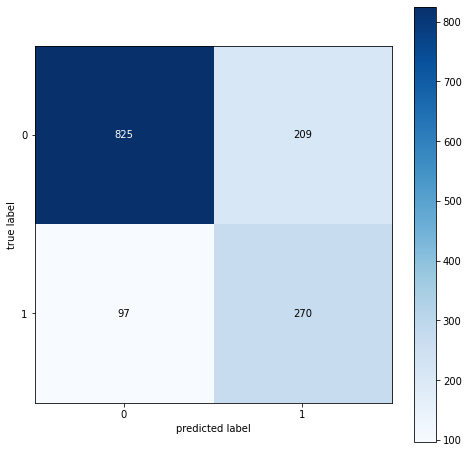

In [63]:
pred = model_predict.copy()
pred[pred >= 0.326] = 1
pred[pred < 0.326] = 0

cm = skplt.metrics.confusion_matrix(y_true=y, y_pred=pred)
plot_confusion_matrix(cm, figsize=(8, 8), colorbar=True);

The model now predicts a higher number of potential churners, in order to optimize the true positive rate and false positive rate.

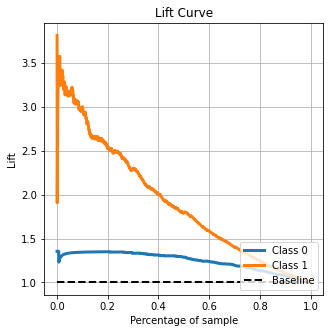

In [64]:
# Lift Chart
skplt.metrics.plot_lift_curve(test["Churn_Yes"], proba.T, figsize=(5, 5));

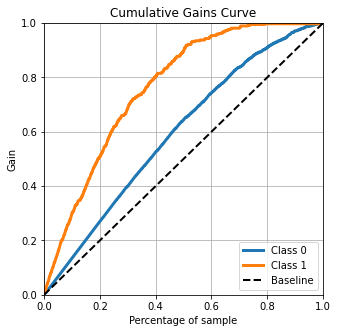

In [65]:
# Gain Chart
skplt.metrics.plot_cumulative_gain(test["Churn_Yes"], proba.T, figsize=(5, 5));

# Resampling methods

As a final part, I are going to perform a nonparametric bootstrap to assess the precision of the estimates.

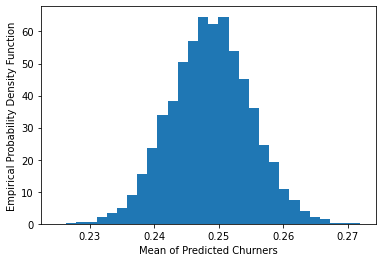

In [66]:
def bootstrap_replicate(data, function):
    bs_sample = np.random.choice(data, len(data))
    return function(bs_sample)

bs_results = np.empty(10000)

for i in range(10000):
    bs_results[i] = bootstrap_replicate(model_predict, np.mean)

_ = plt.hist(bs_results, bins = 30, density = True)
_ = plt.xlabel("Mean of Predicted Churners")
_ = plt.ylabel("Empirical Probability Density Function")
plt.show()

In [67]:
print("Bootstrap confidence interval:", np.percentile(bs_results, [2.5, 97.5]))
print("Bootstrap mean:", round(bs_results.mean(), 3))

Bootstrap confidence interval: [0.23674268 0.26093588]
Bootstrap mean: 0.249


Let's compare the estimates of our prediction with the mean of the sample.

In [68]:
print("Sample mean:", round(test.Churn_Yes.mean(), 3))

Sample mean: 0.262


Prediction is very close to the actual churn rate of the sample.

# Concluding thoughts

Many companies are diverting resources away from the goal of capturing new customers and are instead focusing on retaining the existing ones. The commercial relationship with customers must be kept and reinforced, and, for this purpose, companies should build strong customer defection-avoiding schemes.

That is why companies must have a reliable prediction model that allows them to identify,with enough anticipation, those clients that show symptoms of propensity to switch service providers and, thus, launch efficient retention actions.

However, there may be clients that the company will decide not to retain even if their intention to change is identified in advance, since the expected return on the prolongation of their customer life does not justify the cost of the necessary commercial action. Since I did not cover this issue, I will leave it for further researches.

Note though that, as reported in Haenlein and Kaplan (2012), careless abandonment of the less profitable customers may lead to unexpected negative reactions from the valuable ones that companies aim to retain.

---

# Appendix

This regression aims to assess the correlation between additional internet services and Churn also for low values of tenure. I want to prove that the impact of additional services on Churn is causal and not due to an omitted variable or selection bias. This means that additional services are not given as gift to those clients with a higher tenure but they have an actual impact on the churn phenomenon.

In [69]:
low_tenure = tcc[tcc["tenure_0:18"]+tcc["tenure_19:36"]==1]

variables = low_tenure[['SeniorCitizen',
        'Dependents_Yes', 'MultipleLines_Yes',
         'InternetService_DSL', 'InternetService_Fiber optic', 'OnlineSecurity_Yes',
        'TechSupport_Yes', "OnlineBackup_Yes", 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Automatic', 'tenure_19:36',
       'tenure_37:54', 'tenure_55:72','intercept']]

# Setting the model
logistical_regression_low = sm.Logit(low_tenure["Churn_Yes"], variables)

# Fitting the model
fitted_model_low = logistical_regression.fit()
fitted_model_low.summary2()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Logit
============================================================================
Model:                   Logit                 Pseudo R-squared:      inf   
Dependent Variable:      Churn_Yes             AIC:                   inf   
Date:                    2021-08-23 18:41      BIC:                   inf   
No. Observations:        5631                  Log-Likelihood:        -inf  
Df Model:                17                    LL-Null:               0.0000
Df Residuals:            5613                  LLR p-value:           1.0000
Converged:               1.0000                Scale:                 1.0000
No. Iterations:          8.0000                                             
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
SeniorCitizen                0.2452   0.0923   2.6564 0.0079  0.0643  0.4261
Dependents_Yes              -0.1603   0.0907  -1.7674 0.0772 -0.3381  0.0175
MultipleLines_Yes            0.1333   0.0844   1.5798 0.1142 -0.0321  0.2986
InternetService_DSL          1.0461   0.1461   7.1582 0.0000  0.7596  1.3325
InternetService_Fiber optic  1.9091   0.1491  12.8014 0.0000  1.6168  2.2014
OnlineSecurity_Yes          -0.4100   0.0927  -4.4246 0.0000 -0.5916 -0.2284
TechSupport_Yes             -0.3280   0.0940  -3.4894 0.0005 -0.5122 -0.1437
OnlineBackup_Yes            -0.1933   0.0833  -2.3206 0.0203 -0.3566 -0.0300
StreamingTV_Yes              0.2801   0.0871   3.2166 0.0013  0.1094  0.4508
StreamingMovies_Yes          0.2576   0.0865   2.9779 0.0029  0.0881  0.4272
Contract_One year           -0.8316   0.1178  -7.0587 0.0000 -1.0625 -0.6007
Contract_Two year           -1.5902   0.1919  -8.2879 0.0000 -1.9663 -1.2142
PaperlessBilling_Yes         0.2733   0.0823   3.3213 0.0009  0.1120  0.4345
PaymentMethod_Automatic     -0.3243   0.0800  -4.0548 0.0001 -0.4810 -0.1675
tenure_19:36                -0.9579   0.1015  -9.4395 0.0000 -1.1569 -0.7590
tenure_37:54                -0.9594   0.1219  -7.8725 0.0000 -1.1982 -0.7205
tenure_55:72                -1.4537   0.1532  -9.4913 0.0000 -1.7539 -1.1535
intercept                   -1.5381   0.1281 -12.0089 0.0000 -1.7891 -1.2870
============================================================================

"""